# Team 1: Thermal Advection Term

## 1) Imports

In [1]:
import sys
sys.path.append('/home/decker/lab433')

from datetime import datetime

from synoptic import MODEL

from metpy.units import units
from metpy.constants import dry_air_gas_constant as R
from metpy.io import GempakGrid
import metpy.calc as mpcalc
from metpy.plots import FilledContourPlot, MapPanel, PanelContainer, ContourPlot
import numpy as np
import xarray as xr

## 2) Get the data

In [2]:
gem_file_name = MODEL + 'nam/24101612_nam211.gem'
gem_file = GempakGrid(gem_file_name)
plot_time = datetime(2024, 10, 16, 18)

In [3]:
pressure = 850 
ht850 = gem_file.gdxarray(parameter='HGHT', date_time=plot_time, level=pressure)[0] * units('m')


geoV0u, geoV0v = mpcalc.geostrophic_wind(ht850)

geoV0u = geoV0u.rename('u')
geoV0v = geoV0v.rename('v')

geo850 = xr.merge([geoV0u,geoV0v])


In [4]:

# More code below
tmpk = gem_file.gdxarray(parameter='TMPK', date_time=plot_time, level=pressure)[0]
hght = gem_file.gdxarray(parameter='HGHT', date_time=plot_time, level=pressure)[0]

smoothing = 16
tmpk_smooth = mpcalc.smooth_gaussian(tmpk,smoothing)
hght_smooth = mpcalc.smooth_gaussian(hght,smoothing)


geoV0u, geoV0v = mpcalc.geostrophic_wind(hght_smooth)

geoV0u = geoV0u.rename('u')
geoV0v = geoV0v.rename('v')

geo850 = xr.merge([geoV0u,geoV0v])


tmpk = tmpk * units('degK')
hght = hght * units('m')


temp_adv = mpcalc.advection(tmpk_smooth,geoV0u,geoV0v)
laplacian_temp = mpcalc.laplacian(temp_adv.squeeze(['time','pres']) )
laplacian = -R / pressure * laplacian_temp
total = laplacian

## 3) Calculate

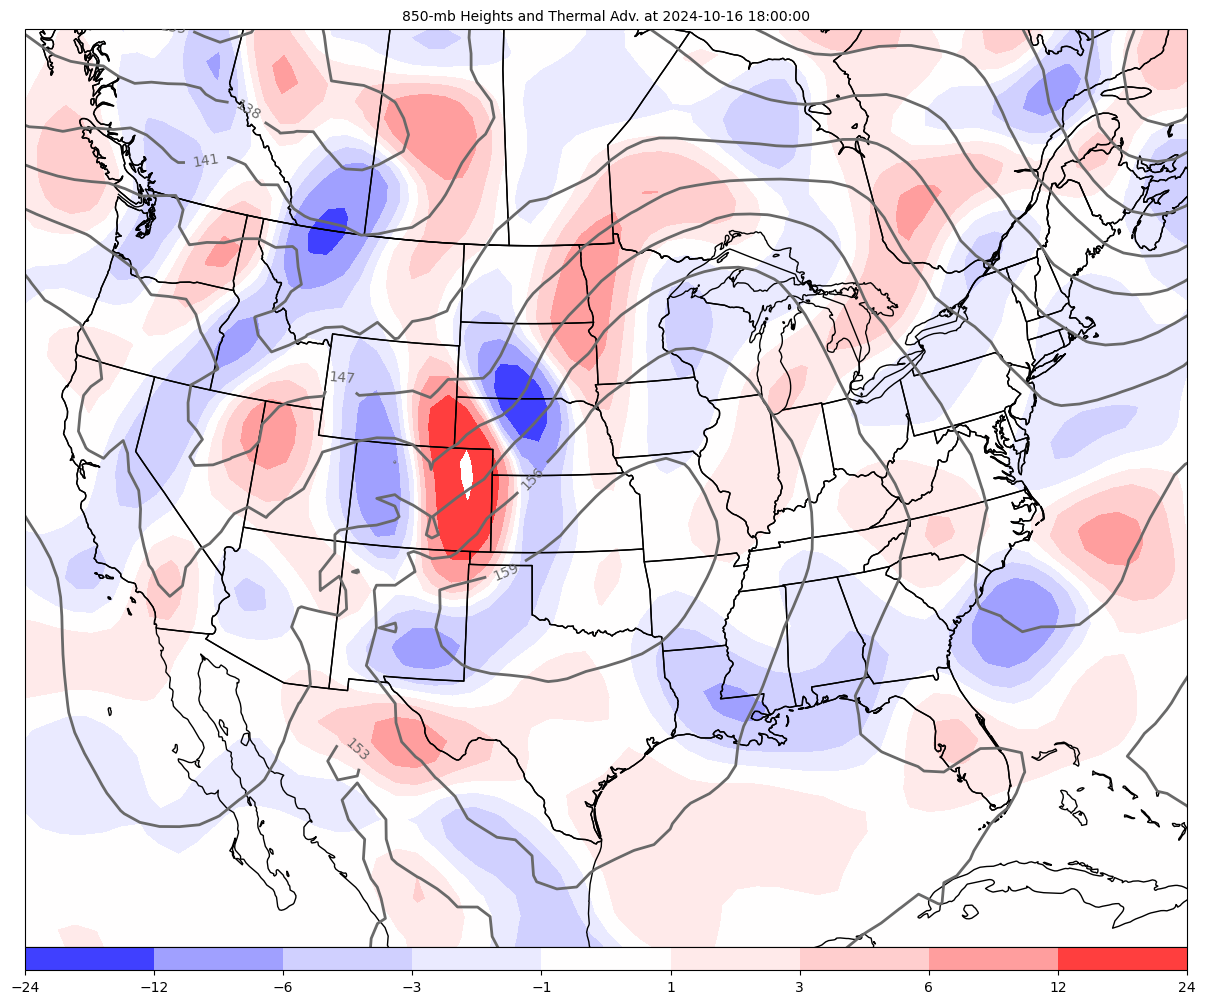

In [5]:
# Your code
isohypses = ContourPlot()
isohypses.data = hght
isohypses.contours = range(0,400,3)
isohypses.linecolor = 'dimgray'
isohypses.linestyle = 'solid'
isohypses.clabels = True
isohypses.plot_units = 'dam'

fills = FilledContourPlot()
fills.data = total
fills.contours = [-24,-12,-6,-3,-1,1,3,6,12,24]
fills.scale = 1e16
fills.colormap = 'bwr'
fills.colorbar = 'horizontal'

panel = MapPanel()
panel.area = [-120, -74, 22, 55]
panel.projection = 'lcc'
panel.layers = ['states', 'coastline', 'borders']
panel.title = f'850-mb Heights and Thermal Adv. at {plot_time}'
panel.plots = [fills, isohypses]

pc = PanelContainer()
pc.size = (15, 15)
pc.panels = [panel]
pc.show()

## 4) Plot it